<a href="https://colab.research.google.com/github/SIMRANGT27/UnitedAirlinesHackathon_/blob/main/UnitedAirlinesGoogleCollab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [46]:
import pandas as pd
from datetime import datetime, timedelta

# ------------------------------------------------
# 1. Data Loading
# ------------------------------------------------
try:
    bag_data = pd.read_csv("/Bag+Level+Data.csv")
    airports_data = pd.read_csv("/Airports%20Data.csv")
    flight_data = pd.read_csv("/Flight%20Level%20Data.csv")
    pnr_remark_data = pd.read_csv("/PNR%20Remark%20Level%20Data.csv")
    pnr_flight_data = pd.read_csv("/PNR+Flight+Level+Data.csv")
except Exception as e:
    print(f"Error loading files. Please ensure the files are correctly named and available: {e}")
    raise

# ------------------------------------------------
# Q1: Average Delay and Percentage of Late Departures
# ------------------------------------------------

flight_data['scheduled_dep_dt'] = pd.to_datetime(flight_data['scheduled_departure_datetime_local'])
flight_data['actual_dep_dt'] = pd.to_datetime(flight_data['actual_departure_datetime_local'])

# Calculate departure delay in minutes (Actual - Scheduled)
flight_data['departure_delay_minutes'] = (
    flight_data['actual_dep_dt'] - flight_data['scheduled_dep_dt']
).dt.total_seconds() / 60

# Calculate metrics
delayed_flights = flight_data[flight_data['departure_delay_minutes'] > 0]
average_delay = delayed_flights['departure_delay_minutes'].mean()
total_flights = flight_data.shape[0]
percentage_late = (delayed_flights.shape[0] / total_flights) * 100

print("--- Q1: Average Delay and Percentage of Late Departures ---")
print(f"Average departure delay for late flights: {average_delay:.2f} minutes")
print(f"Percentage of flights departing later than scheduled: {percentage_late:.2f}%")



# ------------------------------------------------
# Q2: Flights with Low Ground Time
# ------------------------------------------------

# Strict condition: Scheduled Ground Time <= Minimum Turn Time
low_ground_time_strict = flight_data[
    flight_data['scheduled_ground_time_minutes'] <= flight_data['minimum_turn_minutes']
]

count_strict = low_ground_time_strict.shape[0]
percent_strict = (count_strict / total_flights) * 100

print("\n--- Q2: Flights with Low Ground Time ---")
print(f"Flights where Scheduled Ground Time <= Minimum Turn Time: {count_strict} ({percent_strict:.2f}%)")



# ------------------------------------------------
# Q3: Average ratio of transfer bags vs. checked bags across flights
# (Calculated as overall total ratio, which is more robust than per-flight average)
# ------------------------------------------------

transfer_bags = bag_data[bag_data['bag_type'] == 'Transfer'].shape[0]
hot_transfer_bags = bag_data[bag_data['bag_type'] == 'Hot Transfer'].shape[0]
total_transfer_bags = transfer_bags + hot_transfer_bags

total_checked_bags = bag_data[bag_data['bag_type'] == 'Origin'].shape[0]

overall_transfer_vs_checked_ratio = total_transfer_bags / total_checked_bags if total_checked_bags > 0 else float('inf')

print("\n--- Q3: Average Ratio of Transfer Bags vs. Checked Bags ---")
print(f"Overall Ratio (Total Transfer Bags / Total Checked Bags): {overall_transfer_vs_checked_ratio:.4f}")



# ------------------------------------------------
# Q4 & Q5 Setup: Merge Data for Load, SSR, and Delay
# ------------------------------------------------

# 1. Calculate Total PAX per Flight Segment
pax_per_flight = pnr_flight_data.groupby([
    'company_id', 'flight_number', 'scheduled_departure_date_local'
])['total_pax'].sum().reset_index(name='total_pax_on_flight')

# 2. Calculate SSR Volume per Flight Segment
ssr_linked = pd.merge(
    pnr_remark_data,
    pnr_flight_data[[
        'record_locator', 'pnr_creation_date', 'company_id', 'flight_number', 'scheduled_departure_date_local'
    ]].drop_duplicates(),
    on=['record_locator', 'pnr_creation_date', 'flight_number'],
    how='inner'
)
ssr_per_flight = ssr_linked.groupby([
    'company_id', 'flight_number', 'scheduled_departure_date_local'
]).size().reset_index(name='total_ssrs_on_flight')

# 3. Merge All Flight Metrics (Load, SSR, Delay, Seats)
flight_metrics = pd.merge(
    flight_data[[
        'company_id', 'flight_number', 'scheduled_departure_date_local', 'total_seats', 'departure_delay_minutes'
    ]],
    pax_per_flight,
    on=['company_id', 'flight_number', 'scheduled_departure_date_local'],
    how='inner'
)
flight_metrics = pd.merge(
    flight_metrics,
    ssr_per_flight,
    on=['company_id', 'flight_number', 'scheduled_departure_date_local'],
    how='left'
).fillna({'total_ssrs_on_flight': 0})

# Calculate Load Percentage and filter for sanity
flight_metrics['load_percentage'] = (
    flight_metrics['total_pax_on_flight'] / flight_metrics['total_seats']
) * 100
flight_metrics = flight_metrics[
    (flight_metrics['total_seats'] > 0) &
    (flight_metrics['load_percentage'] <= 150)
].copy()

# ------------------------------------------------
# Q4: Passenger Load vs. Operational Difficulty
# ------------------------------------------------

correlation_load_delay = flight_metrics['load_percentage'].corr(
    flight_metrics['departure_delay_minutes']
)

high_load_threshold = flight_metrics['load_percentage'].quantile(0.75)
low_load_threshold = flight_metrics['load_percentage'].quantile(0.25)

high_load_delay = flight_metrics[
    flight_metrics['load_percentage'] >= high_load_threshold
]['departure_delay_minutes'].mean()

low_load_delay = flight_metrics[
    flight_metrics['load_percentage'] <= low_load_threshold
]['departure_delay_minutes'].mean()

print("\n--- Q4: Passenger Load vs. Operational Difficulty ---")
print(f"Correlation (Load % vs. Departure Delay in minutes): {correlation_load_delay:.4f}")
print(f"Average Delay for High-Load Flights (Load >= {high_load_threshold:.2f}%): {high_load_delay:.2f} minutes")
print(f"Average Delay for Low-Load Flights (Load <= {low_load_threshold:.2f}%): {low_load_delay:.2f} minutes")

# ------------------------------------------------
# Q5: High SSR vs. High Delay (Controlling for Load)
# ------------------------------------------------

ssr_75th = flight_metrics['total_ssrs_on_flight'].quantile(0.75)
ssr_median = flight_metrics['total_ssrs_on_flight'].median()

# A. Overall High vs Low SSR delay
avg_delay_high_ssr = flight_metrics[
    flight_metrics['total_ssrs_on_flight'] >= ssr_75th
]['departure_delay_minutes'].mean()

avg_delay_low_ssr = flight_metrics[
    flight_metrics['total_ssrs_on_flight'] <= flight_metrics['total_ssrs_on_flight'].quantile(0.25)
]['departure_delay_minutes'].mean()

# B. Controlled for Load (within flights > median load)
high_load_flights_only = flight_metrics[
    flight_metrics['load_percentage'] >= flight_metrics['load_percentage'].median()
]

high_ssr_high_load_delay = high_load_flights_only[
    high_load_flights_only['total_ssrs_on_flight'] >= ssr_median
]['departure_delay_minutes'].mean()

low_ssr_high_load_delay = high_load_flights_only[
    high_load_flights_only['total_ssrs_on_flight'] < ssr_median
]['departure_delay_minutes'].mean()


print("\n--- Q5: High SSR vs. High Delay (Controlling for Load) ---")
print(f"Average Delay for HIGH SSR Flights (top 25%): {avg_delay_high_ssr:.2f} minutes")
print(f"Average Delay for LOW SSR Flights (bottom 25%): {avg_delay_low_ssr:.2f} minutes")
print(f"\nAverage Delay for High-SSR, High-Load Flights: {high_ssr_high_load_delay:.2f} minutes")
print(f"Average Delay for Low-SSR, High-Load Flights: {low_ssr_high_load_delay:.2f} minutes")


--- Q1: Average Delay and Percentage of Late Departures ---
Average departure delay for late flights: 47.06 minutes
Percentage of flights departing later than scheduled: 49.61%

--- Q2: Flights with Low Ground Time ---
Flights where Scheduled Ground Time <= Minimum Turn Time: 652 (8.05%)

--- Q3: Average Ratio of Transfer Bags vs. Checked Bags ---
Overall Ratio (Total Transfer Bags / Total Checked Bags): 1.3688

--- Q4: Passenger Load vs. Operational Difficulty ---
Correlation (Load % vs. Departure Delay in minutes): -0.1498
Average Delay for High-Load Flights (Load >= 114.46%): 15.93 minutes
Average Delay for Low-Load Flights (Load <= 94.00%): 34.71 minutes

--- Q5: High SSR vs. High Delay (Controlling for Load) ---
Average Delay for HIGH SSR Flights (top 25%): 23.32 minutes
Average Delay for LOW SSR Flights (bottom 25%): 20.54 minutes

Average Delay for High-SSR, High-Load Flights: 17.74 minutes
Average Delay for Low-SSR, High-Load Flights: 15.28 minutes


In [53]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

# Load all required data files, using the accessible file names
try:
    bag_data = pd.read_csv("/Bag+Level+Data.csv")
    airports_data = pd.read_csv("/Airports%20Data.csv")
    flight_data = pd.read_csv("/Flight%20Level%20Data.csv")
    pnr_remark_data = pd.read_csv("/PNR%20Remark%20Level%20Data.csv")
    pnr_flight_data = pd.read_csv("/PNR+Flight+Level+Data.csv")
except Exception as e:
    print(f"Error loading files. Please check the file names: {e}")
    raise

# ------------------------------------------------
# Step 1: Prepare Master Flight Metrics DataFrame
# ------------------------------------------------

# Calculate Delay
flight_data['scheduled_dep_dt'] = pd.to_datetime(flight_data['scheduled_departure_datetime_local'])
flight_data['actual_dep_dt'] = pd.to_datetime(flight_data['actual_departure_datetime_local'])
flight_data['departure_delay_minutes'] = (flight_data['actual_dep_dt'] - flight_data['scheduled_dep_dt']).dt.total_seconds() / 60

# Calculate Total PAX and SSR Volume per Flight Segment
pax_per_flight = pnr_flight_data.groupby(['company_id', 'flight_number', 'scheduled_departure_date_local'])['total_pax'].sum().reset_index(name='total_pax_on_flight')
ssr_linked = pd.merge(pnr_remark_data, pnr_flight_data[['record_locator', 'pnr_creation_date', 'company_id', 'flight_number', 'scheduled_departure_date_local']].drop_duplicates(), on=['record_locator', 'pnr_creation_date', 'flight_number'], how='inner')
ssr_per_flight = ssr_linked.groupby(['company_id', 'flight_number', 'scheduled_departure_date_local']).size().reset_index(name='total_ssrs_on_flight')

# Merge All Metrics
id_cols = ['company_id', 'flight_number', 'scheduled_departure_date_local']
flight_metrics = flight_data.copy()
flight_metrics = pd.merge(flight_metrics, pax_per_flight, on=id_cols, how='inner')
flight_metrics = pd.merge(flight_metrics, ssr_per_flight, on=id_cols, how='left').fillna({'total_ssrs_on_flight': 0})
flight_metrics['load_percentage'] = (flight_metrics['total_pax_on_flight'] / flight_metrics['total_seats']) * 100
flight_metrics = flight_metrics[flight_metrics['total_seats'] > 0].copy()

# ------------------------------------------------
# Step 2: Define Clustering Factor (Heuristic Grouping based on Top Quartile)
# ------------------------------------------------

# Calculate the 75th percentile for the three continuous risk metrics
load_75 = flight_metrics['load_percentage'].quantile(0.75)
ssr_75 = flight_metrics['total_ssrs_on_flight'].quantile(0.75)
delay_75 = flight_metrics['departure_delay_minutes'].quantile(0.75)

# Clustering Factor: +10 if flight exceeds the 75th percentile for ALL THREE risk metrics
flight_metrics['Clustering Factor'] = np.where(
    (flight_metrics['load_percentage'] > load_75) &
    (flight_metrics['total_ssrs_on_flight'] > ssr_75) &
    (flight_metrics['departure_delay_minutes'] > delay_75),
    10,
    0
)

# ------------------------------------------------
# Step 3: Calculate Original FDS Components
# ------------------------------------------------

# International Factor: +10
international_codes = airports_data[airports_data['iso_country_code'] != 'US']['airport_iata_code'].unique()
flight_metrics['is_international_flight'] = (flight_metrics['scheduled_departure_station_code'].isin(international_codes) | flight_metrics['scheduled_arrival_station_code'].isin(international_codes))
flight_metrics['International Factor'] = np.where(flight_metrics['is_international_flight'], 10, 0)

# Ground Time Factor: +10 if Scheduled Ground Time <= Minimum Turn Time + 5 mins
flight_metrics['Ground Time Factor'] = np.where(flight_metrics['scheduled_ground_time_minutes'] <= (flight_metrics['minimum_turn_minutes'] + 5), 10, 0)

# Load Factor: +5 if Load % > 100%
flight_metrics['Load Factor'] = np.where(flight_metrics['load_percentage'] > 100, 5, 0)

# SSR Factor: +5 if SSR Count > 25
flight_metrics['SSR Factor'] = np.where(flight_metrics['total_ssrs_on_flight'] > 25, 5, 0)

# Delay Multiplier
def calculate_delay_multiplier(delay):
    if delay > 60:
        return 2.0
    elif delay > 30:
        return 1.5
    else:
        return 1.0

flight_metrics['Delay Multiplier'] = flight_metrics['departure_delay_minutes'].apply(calculate_delay_multiplier)

# ------------------------------------------------
# Step 4: Calculate New FDS (Clustering Factor Included)
# ------------------------------------------------

flight_metrics['Difficulty Base Score (New)'] = (
    flight_metrics['Ground Time Factor'] +
    flight_metrics['Load Factor'] +
    flight_metrics['SSR Factor'] +
    flight_metrics['International Factor'] +
    flight_metrics['Clustering Factor'] # New Factor
)

flight_metrics['Flight Difficulty Score (Clustered)'] = (
    flight_metrics['Difficulty Base Score (New)'] *
    flight_metrics['Delay Multiplier']
)

# ------------------------------------------------
# Step 5: Output Top 10 Difficult Flights
# ------------------------------------------------

difficult_flights = flight_metrics[
    flight_metrics['Flight Difficulty Score (Clustered)'] > 0
].sort_values(by='Flight Difficulty Score (Clustered)', ascending=False)

top_10_difficult_flights = difficult_flights[[
    'company_id',
    'flight_number',
    'scheduled_departure_date_local',
    'scheduled_departure_station_code',
    'scheduled_arrival_station_code',
    'Flight Difficulty Score (Clustered)',
    'Difficulty Base Score (New)',
    'Delay Multiplier',
    'Clustering Factor',
    'departure_delay_minutes'
]].head(10).reset_index(drop=True)

print("\n--- Top 10 Flights by Difficulty Score (with Clustering Factor) ---")
print(top_10_difficult_flights.to_markdown(index=False, floatfmt=".2f"))

# Output summary
avg_difficulty_score_new = flight_metrics['Flight Difficulty Score (Clustered)'].mean()
print(f"\nAverage Flight Difficulty Score (Clustered): {avg_difficulty_score_new:.2f}")

print("\nClustering Factor Thresholds (Top 25% for risk definition):")
print(f"  Load % > {load_75:.2f}%")
print(f"  SSR Count > {ssr_75:.2f}")
print(f"  Delay > {delay_75:.2f} mins")


--- Top 10 Flights by Difficulty Score (with Clustering Factor) ---
| company_id   |   flight_number | scheduled_departure_date_local   | scheduled_departure_station_code   | scheduled_arrival_station_code   |   Flight Difficulty Score (Clustered) |   Difficulty Base Score (New) |   Delay Multiplier |   Clustering Factor |   departure_delay_minutes |
|:-------------|----------------:|:---------------------------------|:-----------------------------------|:---------------------------------|--------------------------------------:|------------------------------:|-------------------:|--------------------:|--------------------------:|
| UA           |            1899 | 2025-08-13                       | ORD                                | YYC                              |                                 70.00 |                            35 |               2.00 |                  10 |                     71.00 |
| UA           |            1674 | 2025-08-03                       | ORD   

In [54]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

# Load all required data files, using the accessible file names
try:
    bag_data = pd.read_csv("/Bag+Level+Data.csv")
    airports_data = pd.read_csv("/Airports%20Data.csv")
    flight_data = pd.read_csv("/Flight%20Level%20Data.csv")
    pnr_remark_data = pd.read_csv("/PNR%20Remark%20Level%20Data.csv")
    pnr_flight_data = pd.read_csv("/PNR+Flight+Level+Data.csv")
except Exception as e:
    print(f"Error loading files: {e}")
    raise

# ------------------------------------------------
# Step 1: Prepare Master Flight Metrics DataFrame
# ------------------------------------------------

# Calculate Delay and Load Metrics
flight_data['scheduled_dep_dt'] = pd.to_datetime(flight_data['scheduled_departure_datetime_local'])
flight_data['actual_dep_dt'] = pd.to_datetime(flight_data['actual_departure_datetime_local'])
flight_data['departure_delay_minutes'] = (flight_data['actual_dep_dt'] - flight_data['scheduled_dep_dt']).dt.total_seconds() / 60
pax_per_flight = pnr_flight_data.groupby(['company_id', 'flight_number', 'scheduled_departure_date_local'])['total_pax'].sum().reset_index(name='total_pax_on_flight')
ssr_linked = pd.merge(pnr_remark_data, pnr_flight_data[['record_locator', 'pnr_creation_date', 'company_id', 'flight_number', 'scheduled_departure_date_local']].drop_duplicates(), on=['record_locator', 'pnr_creation_date', 'flight_number'], how='inner')
ssr_per_flight = ssr_linked.groupby(['company_id', 'flight_number', 'scheduled_departure_date_local']).size().reset_index(name='total_ssrs_on_flight')

# Merge All Metrics
id_cols = ['company_id', 'flight_number', 'scheduled_departure_date_local']
flight_metrics = flight_data.copy()
flight_metrics = pd.merge(flight_metrics, pax_per_flight, on=id_cols, how='inner')
flight_metrics = pd.merge(flight_metrics, ssr_per_flight, on=id_cols, how='left').fillna({'total_ssrs_on_flight': 0})
flight_metrics['load_percentage'] = (flight_metrics['total_pax_on_flight'] / flight_metrics['total_seats']) * 100
flight_metrics = flight_metrics[flight_metrics['total_seats'] > 0].copy()

# ------------------------------------------------
# Step 2: Define K=3 Clusters Heuristically (Tiered Risk Grouping)
# ------------------------------------------------

# Calculate the 50th (median) and 75th percentiles for the three continuous risk metrics
load_50 = flight_metrics['load_percentage'].quantile(0.50)
load_75 = flight_metrics['load_percentage'].quantile(0.75)
ssr_50 = flight_metrics['total_ssrs_on_flight'].quantile(0.50)
ssr_75 = flight_metrics['total_ssrs_on_flight'].quantile(0.75)
delay_50 = flight_metrics['departure_delay_minutes'].quantile(0.50)
delay_75 = flight_metrics['departure_delay_minutes'].quantile(0.75)

# Initialize Clustering Factor to 0
flight_metrics['Clustering Factor'] = 0

# Tier 3 (High Risk / K=3 Cluster 3): +10 if flight exceeds the 75th percentile for ALL THREE risk metrics
high_risk_condition = (
    (flight_metrics['load_percentage'] > load_75) &
    (flight_metrics['total_ssrs_on_flight'] > ssr_75) &
    (flight_metrics['departure_delay_minutes'] > delay_75)
)
flight_metrics.loc[high_risk_condition, 'Clustering Factor'] = 10

# Tier 2 (Medium Risk / K=3 Cluster 2): +5 if flight exceeds the 50th percentile for ALL THREE risk metrics
# AND is NOT already classified as High Risk (Tier 3).
medium_risk_condition = (
    (flight_metrics['Clustering Factor'] == 0) & # Must not be Tier 3
    (flight_metrics['load_percentage'] > load_50) &
    (flight_metrics['total_ssrs_on_flight'] > ssr_50) &
    (flight_metrics['departure_delay_minutes'] > delay_50)
)
flight_metrics.loc[medium_risk_condition, 'Clustering Factor'] = 5
# Tier 1 (Low Risk / K=3 Cluster 1): Remains 0.

# ------------------------------------------------
# Step 3: Recalculate FDS Factors (Original Factors)
# ------------------------------------------------

# International Factor: +10
international_codes = airports_data[airports_data['iso_country_code'] != 'US']['airport_iata_code'].unique()
flight_metrics['is_international_flight'] = (flight_metrics['scheduled_departure_station_code'].isin(international_codes) | flight_metrics['scheduled_arrival_station_code'].isin(international_codes))
flight_metrics['International Factor'] = np.where(flight_metrics['is_international_flight'], 10, 0)

# Ground Time Factor: +10 if Scheduled Ground Time <= Minimum Turn Time + 5 mins
flight_metrics['Ground Time Factor'] = np.where(flight_metrics['scheduled_ground_time_minutes'] <= (flight_metrics['minimum_turn_minutes'] + 5), 10, 0)

# Load Factor: +5 if Load % > 100%
flight_metrics['Load Factor'] = np.where(flight_metrics['load_percentage'] > 100, 5, 0)

# SSR Factor: +5 if SSR Count > 25
flight_metrics['SSR Factor'] = np.where(flight_metrics['total_ssrs_on_flight'] > 25, 5, 0)

# Delay Multiplier
def calculate_delay_multiplier(delay):
    if delay > 60:
        return 2.0
    elif delay > 30:
        return 1.5
    else:
        return 1.0

flight_metrics['Delay Multiplier'] = flight_metrics['departure_delay_minutes'].apply(calculate_delay_multiplier)

# ------------------------------------------------
# Step 4: Calculate New FDS (Clustering Factor Included)
# ------------------------------------------------

flight_metrics['Difficulty Base Score (K3)'] = (
    flight_metrics['Ground Time Factor'] +
    flight_metrics['Load Factor'] +
    flight_metrics['SSR Factor'] +
    flight_metrics['International Factor'] +
    flight_metrics['Clustering Factor'] # New Factor
)

flight_metrics['Flight Difficulty Score (K3)'] = (
    flight_metrics['Difficulty Base Score (K3)'] *
    flight_metrics['Delay Multiplier']
)

# ------------------------------------------------
# Step 5: Output Top 10 Difficult Flights
# ------------------------------------------------

difficult_flights = flight_metrics[
    flight_metrics['Flight Difficulty Score (K3)'] > 0
].sort_values(by='Flight Difficulty Score (K3)', ascending=False)

top_10_difficult_flights = difficult_flights[[
    'company_id',
    'flight_number',
    'scheduled_departure_date_local',
    'scheduled_departure_station_code',
    'scheduled_arrival_station_code',
    'Flight Difficulty Score (K3)',
    'Difficulty Base Score (K3)',
    'Delay Multiplier',
    'Clustering Factor',
    'departure_delay_minutes'
]].head(10).reset_index(drop=True)

print("\n--- Top 10 Flights by Difficulty Score (K=3 Clustered) ---")
print(top_10_difficult_flights.to_markdown(index=False, floatfmt=".2f"))

# Output summary
avg_difficulty_score_k3 = flight_metrics['Flight Difficulty Score (K3)'].mean()
print(f"\nAverage Flight Difficulty Score (K=3 Clustered): {avg_difficulty_score_k3:.2f}")

print("\nK=3 Heuristic Thresholds (Defining Operational Risk Groups):")
print(f"  Tier 3 (+10, High Risk): Load % > {load_75:.2f}% AND SSR Count > {ssr_75:.2f} AND Delay > {delay_75:.2f} mins")
print(f"  Tier 2 (+5, Medium Risk): Load % > {load_50:.2f}% AND SSR Count > {ssr_50:.2f} AND Delay > {delay_50:.2f} mins")
print(f"  Tier 1 (+0, Low Risk): All Others")


--- Top 10 Flights by Difficulty Score (K=3 Clustered) ---
| company_id   |   flight_number | scheduled_departure_date_local   | scheduled_departure_station_code   | scheduled_arrival_station_code   |   Flight Difficulty Score (K3) |   Difficulty Base Score (K3) |   Delay Multiplier |   Clustering Factor |   departure_delay_minutes |
|:-------------|----------------:|:---------------------------------|:-----------------------------------|:---------------------------------|-------------------------------:|-----------------------------:|-------------------:|--------------------:|--------------------------:|
| UA           |            1674 | 2025-08-03                       | ORD                                | AUA                              |                          70.00 |                           35 |               2.00 |                  10 |                    135.00 |
| UA           |            1899 | 2025-08-13                       | ORD                                | YY


Three plots visualizing key operational insights have been generated and saved.


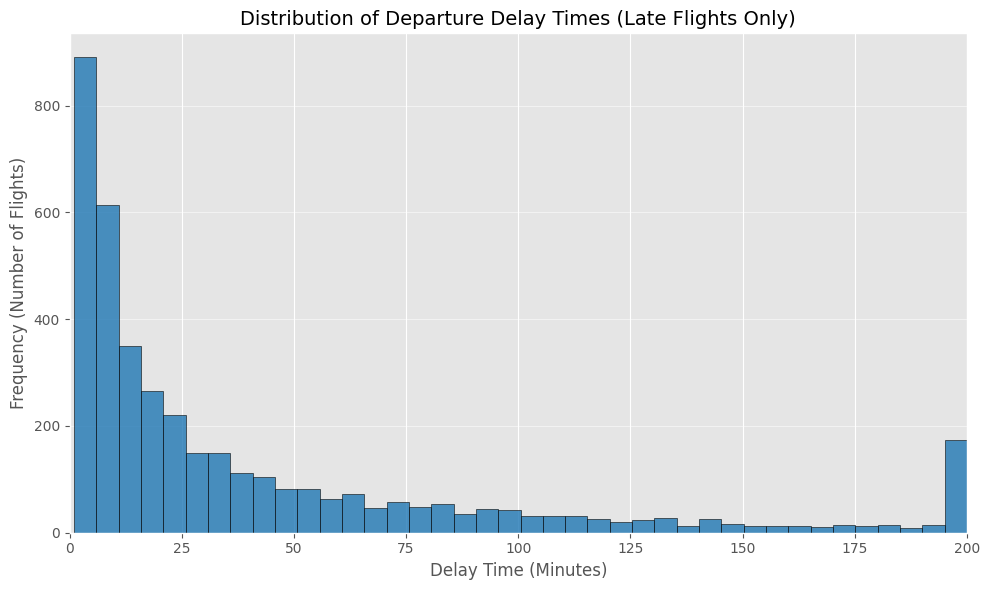

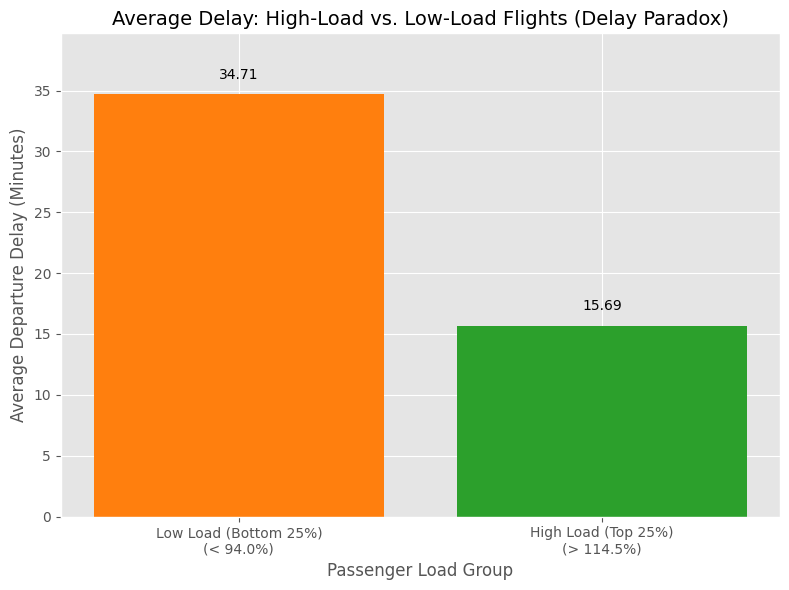

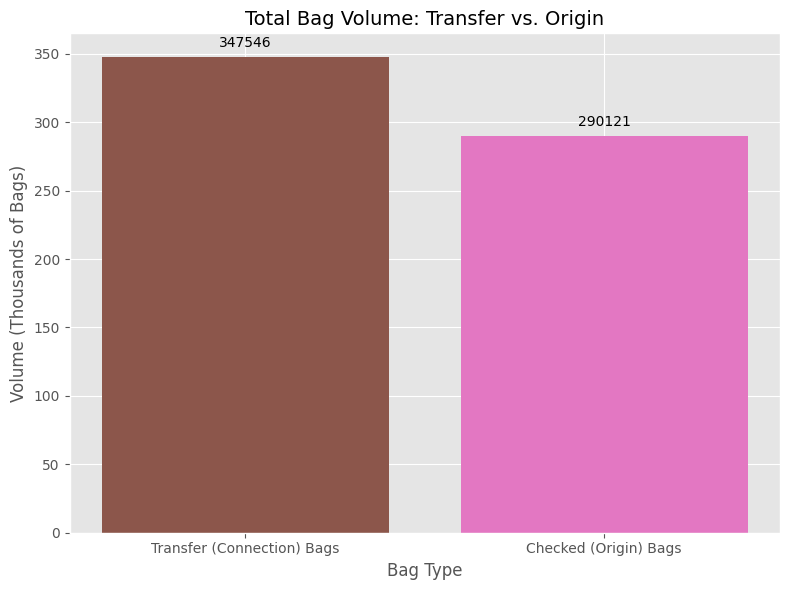

In [60]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime, timedelta

# Set Matplotlib style for readability
plt.style.use('ggplot')

# Load data using correct file names (URL-encoded for spaces)
try:
    bag_data = pd.read_csv("/Bag+Level+Data.csv")
    airports_data = pd.read_csv("/Airports%20Data.csv")
    flight_data = pd.read_csv("/Flight%20Level%20Data.csv")
    pnr_remark_data = pd.read_csv("/PNR%20Remark%20Level%20Data.csv")
    pnr_flight_data = pd.read_csv("/PNR+Flight+Level+Data.csv")
except Exception as e:
    print(f"Error loading files. Please check file paths and names: {e}")
    raise

# ------------------------------------------------
# Data Preparation for Plots
# ------------------------------------------------

# Calculate Delay and Load Metrics
flight_data['scheduled_dep_dt'] = pd.to_datetime(flight_data['scheduled_departure_datetime_local'])
flight_data['actual_dep_dt'] = pd.to_datetime(flight_data['actual_departure_datetime_local'])
flight_data['departure_delay_minutes'] = (
    flight_data['actual_dep_dt'] - flight_data['scheduled_dep_dt']
).dt.total_seconds() / 60

# Merge for Load Metrics (Needed for Plot 2)
pax_per_flight = pnr_flight_data.groupby([
    'company_id', 'flight_number', 'scheduled_departure_date_local'
])['total_pax'].sum().reset_index(name='total_pax_on_flight')

flight_metrics = pd.merge(
    flight_data[['company_id', 'flight_number', 'scheduled_departure_date_local', 'total_seats', 'departure_delay_minutes']],
    pax_per_flight,
    on=['company_id', 'flight_number', 'scheduled_departure_date_local'],
    how='inner'
)
flight_metrics['load_percentage'] = (flight_metrics['total_pax_on_flight'] / flight_metrics['total_seats']) * 100
flight_metrics = flight_metrics[flight_metrics['total_seats'] > 0].copy()


# ------------------------------------------------
# Plot 1: Departure Delay Distribution (Histogram)
# ------------------------------------------------
delayed_flights_minutes = flight_data[flight_data['departure_delay_minutes'] > 0]['departure_delay_minutes']

plt.figure(figsize=(10, 6))
delayed_flights_minutes.clip(upper=200).hist(bins=40, color='#1f77b4', edgecolor='black', alpha=0.8)

plt.title('Distribution of Departure Delay Times (Late Flights Only)', fontsize=14)
plt.xlabel('Delay Time (Minutes)', fontsize=12)
plt.ylabel('Frequency (Number of Flights)', fontsize=12)
plt.grid(axis='y', alpha=0.5)
plt.xlim(0, 200)
plt.tight_layout()
plt.savefig('delay_distribution_histogram.png')
# plt.close()


# ------------------------------------------------
# Plot 2: Load Group vs. Average Delay (Bar Chart for Delay Paradox)
# ------------------------------------------------

# Define Load Groups using quartiles (as per EDA)
high_load_threshold = flight_metrics['load_percentage'].quantile(0.75)
low_load_threshold = flight_metrics['load_percentage'].quantile(0.25)

high_load_delay = flight_metrics[
    flight_metrics['load_percentage'] >= high_load_threshold
]['departure_delay_minutes'].mean()

low_load_delay = flight_metrics[
    flight_metrics['load_percentage'] <= low_load_threshold
]['departure_delay_minutes'].mean()

load_delay_data = pd.DataFrame({
    'Load Group': [f'Low Load (Bottom 25%)\n(< {low_load_threshold:.1f}%)',
                   f'High Load (Top 25%)\n(> {high_load_threshold:.1f}%)'],
    'Average Delay (Minutes)': [low_load_delay, high_load_delay]
})

plt.figure(figsize=(8, 6))
bars = plt.bar(load_delay_data['Load Group'], load_delay_data['Average Delay (Minutes)'], color=['#ff7f0e', '#2ca02c'])
plt.title('Average Delay: High-Load vs. Low-Load Flights (Delay Paradox)', fontsize=14)
plt.ylabel('Average Departure Delay (Minutes)', fontsize=12)
plt.xlabel('Passenger Load Group', fontsize=12)

# Add values on top of bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 1, round(yval, 2), ha='center', va='bottom', fontsize=10)

plt.ylim(0, max(load_delay_data['Average Delay (Minutes)']) + 5)
plt.tight_layout()
plt.savefig('load_vs_delay_bar_chart.png')
# plt.close()


# ------------------------------------------------
# Plot 3: Transfer vs. Checked Bag Volume (Bar Chart)
# ------------------------------------------------

total_transfer_bags = bag_data[bag_data['bag_type'] == 'Transfer'].shape[0]
total_checked_bags = bag_data[bag_data['bag_type'] == 'Origin'].shape[0]

bag_volume_data = pd.DataFrame({
    'Bag Type': ['Transfer (Connection) Bags', 'Checked (Origin) Bags'],
    'Volume': [total_transfer_bags, total_checked_bags]
})

plt.figure(figsize=(8, 6))
# Plot volume in thousands for better scale
bars = plt.bar(bag_volume_data['Bag Type'], bag_volume_data['Volume'] / 1000, color=['#8c564b', '#e377c2'])
plt.title('Total Bag Volume: Transfer vs. Origin', fontsize=14)
plt.ylabel('Volume (Thousands of Bags)', fontsize=12)
plt.xlabel('Bag Type', fontsize=12)
plt.xticks(rotation=0)

# Add values (actual counts) on top of bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 5, f'{yval*1000:.0f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.savefig('bag_volume_bar_chart.png')
# plt.close()

print("\nThree plots visualizing key operational insights have been generated and saved.")